In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("data/esg_return_vol_clean_data.csv")
df.head()

,risk_rating_score,risk_rating_assessment,industry_group,identifier,country,company_name,ticker,return,volatility
0,28.9,Medium Risk,Retailing,NAS:FLWS,United States of America,1-800-flowers-com-inc,FLWS,-0.2236,0.4191
1,27.7,Medium Risk,Telecommunication Services,ETR:1U1,Germany,1-1-ag,1U1.DE,-0.3420,0.2791
2,22.5,Medium Risk,Pharmaceuticals,NAS:TXG,United States of America,10x-genomics-inc,TXG,-0.7357,0.6540
3,16.3,Low Risk,Software & Services,WAR:11B,Poland,11-bit-studios-sa,11B.WA,-0.6866,0.6431
4,35.0,High Risk,Banks,NAS:SRCE,United States of America,1st-source-corp,SRCE,0.1023,0.3087


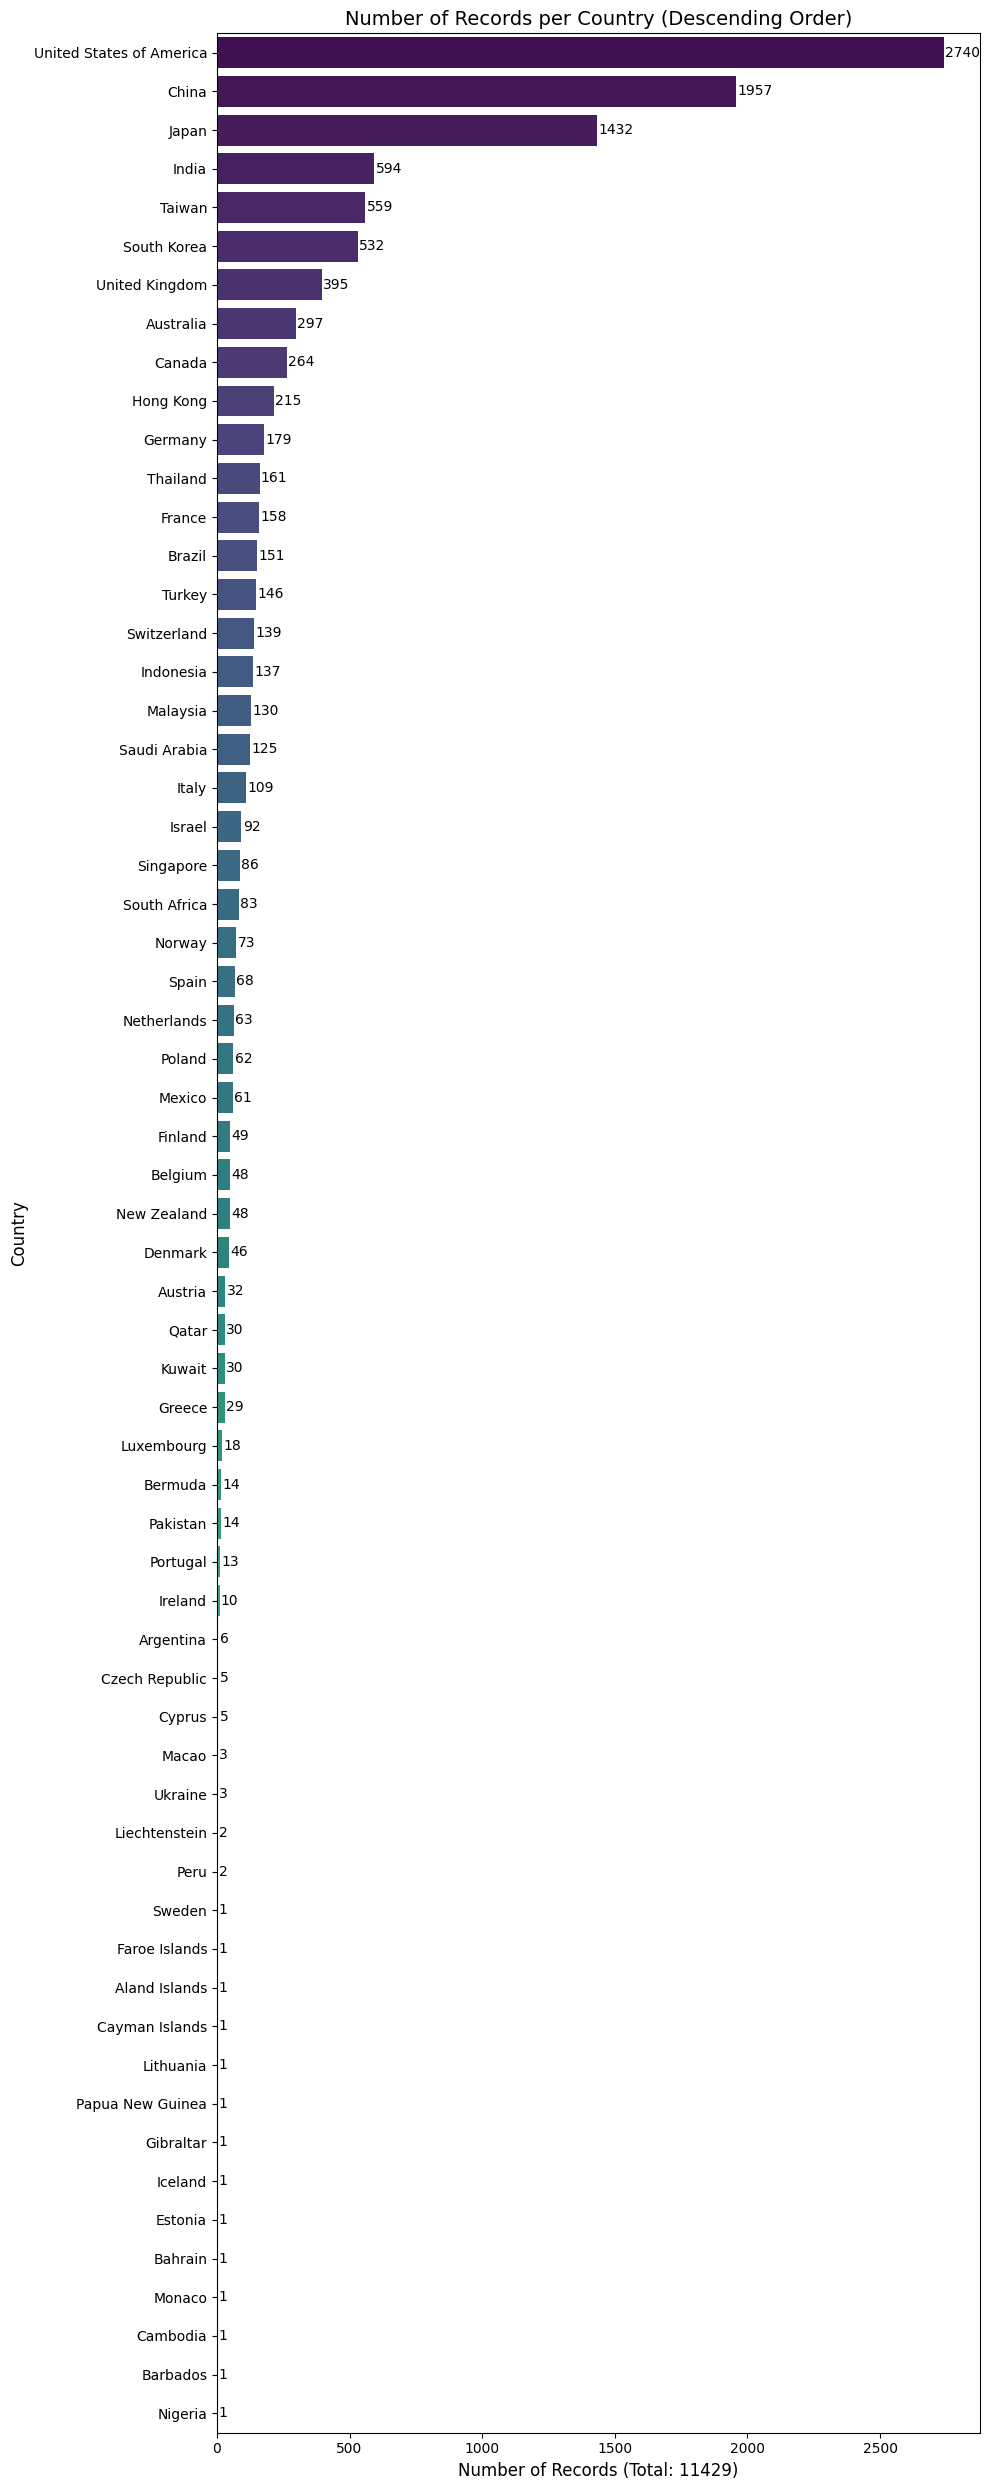

In [5]:
# Count the number of records per country
country_counts = df['country'].value_counts().reset_index()
# Rename columns for clarity
country_counts.columns = ['country', 'count']

# Sort in descending order of count
country_counts = country_counts.sort_values('count', ascending=False)
total_records = country_counts['count'].sum()

# Create a horizontal bar chart using seaborn
# Adjust figure size to accommodate more bars
plt.figure(figsize=(10, 25)) # Increased figure height for 106 bars
ax = sns.barplot(x='count', y='country', data=country_counts, palette='viridis') # Swapped x and y

# Add labels and title
plt.xlabel(f'Number of Records (Total: {total_records})', fontsize=12) # Updated label to include total
plt.ylabel('Country', fontsize=12) # Swapped labels
plt.title('Number of Records per Country (Descending Order)', fontsize=14)

# Add the count of records next to each bar
for index, row in country_counts.iterrows():
    ax.text(row['count'] + 5, index, str(row['count']), color='black', ha="left", va="center") # Add text label

# Ensure layout is tight
plt.tight_layout()
plt.savefig('images/country_wise_count.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [7]:
def prepare_categorical_data(df):
    risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    # Convert to categorical with specified order
    df['risk_rating_assessment'] = pd.Categorical(
        df['risk_rating_assessment'],
        categories=risk_order,
        ordered=True
    )
    # Sort by risk rating
    df = df.sort_values('risk_rating_assessment')
    return df


In [8]:
def basic_analysis(df):
    """Perform initial statistical analysis"""
    # Summary statistics by ESG group
    summary = df.groupby('risk_rating_assessment').agg({
        'return': ['mean', 'median', 'std', 'count'],
        'volatility': ['mean', 'median'],
        'risk_rating_score': ['mean', 'median']  # Show ESG score relationship
    }).round(4)
    
    print("Performance by ESG Group:")
    print(summary)
    
    # Correlation analysis
    corr_matrix = df[['risk_rating_score', 'return', 'volatility']].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    return summary, corr_matrix
def create_visualizations(df):
    """Generate all visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Risk Rating Performance Analysis', fontsize=16)
    
    # Boxplot of returns by risk rating
    sns.boxplot(x='risk_rating_assessment', y='return', data=df, ax=axes[0, 0],
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[0, 0].set_title('Distribution of Returns by Risk Rating')
    axes[0, 0].set_ylabel('Return')
    axes[0, 0].set_xlabel('Risk Rating')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Scatter plot of ESG score vs returns
    sns.regplot(x='risk_rating_score', y='return', data=df, ax=axes[0, 1], 
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    axes[0, 1].set_title('ESG Score vs. Returns')
    axes[0, 1].set_ylabel('Return')
    axes[0, 1].set_xlabel('ESG Score (Risk Rating)')

    
    # Violin plot of volatility by ESG group
    # sns.violinplot(x='risk_rating_score', y='volatility', data=df, ax=axes[1, 0])
    # axes[1, 0].set_title('Volatility by ESG Group')
    # axes[1, 0].set_ylabel('Volatility')
    # axes[1, 0].set_xlabel('ESG Rating Group')
    sns.boxplot(x='risk_rating_assessment', y='volatility', data=df, ax=axes[1, 0],
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[1, 0].set_title('Distribution of Volatility by Risk Rating')
    axes[1, 0].set_ylabel('Volatility')
    axes[1, 0].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Bar plot of average returns
    (df.groupby('risk_rating_assessment')['return']
       .mean()
       .loc[['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']]
       .plot(kind='bar', ax=axes[1, 1]))
    axes[1, 1].set_title('Average Returns by Risk Rating')
    axes[1, 1].set_ylabel('Average Return')
    axes[1, 1].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('images/risk_rating_performance_analysis_rawdata.png', dpi=300, bbox_inches='tight')
    plt.show()


Performance by ESG Group:
                        return                       volatility          \
                          mean  median     std count       mean  median   
risk_rating_assessment                                                    
Negligible Risk         0.0517  0.0173  0.3098   206     0.2879  0.2608   
Low Risk                0.1140  0.0352  1.7872  2828     0.4263  0.3194   
Medium Risk             0.1189  0.0472  0.6820  4646     0.5592  0.3624   
High Risk               0.1063  0.0412  0.4962  2742     0.4444  0.3890   
Severe Risk             0.0906  0.0321  0.4608  1007     0.4604  0.3934   

                       risk_rating_score         
                                    mean median  
risk_rating_assessment                           
Negligible Risk                   8.4199    8.6  
Low Risk                         16.1474   16.5  
Medium Risk                      24.9802   25.0  
High Risk                        34.1376   33.8  
Severe Risk            

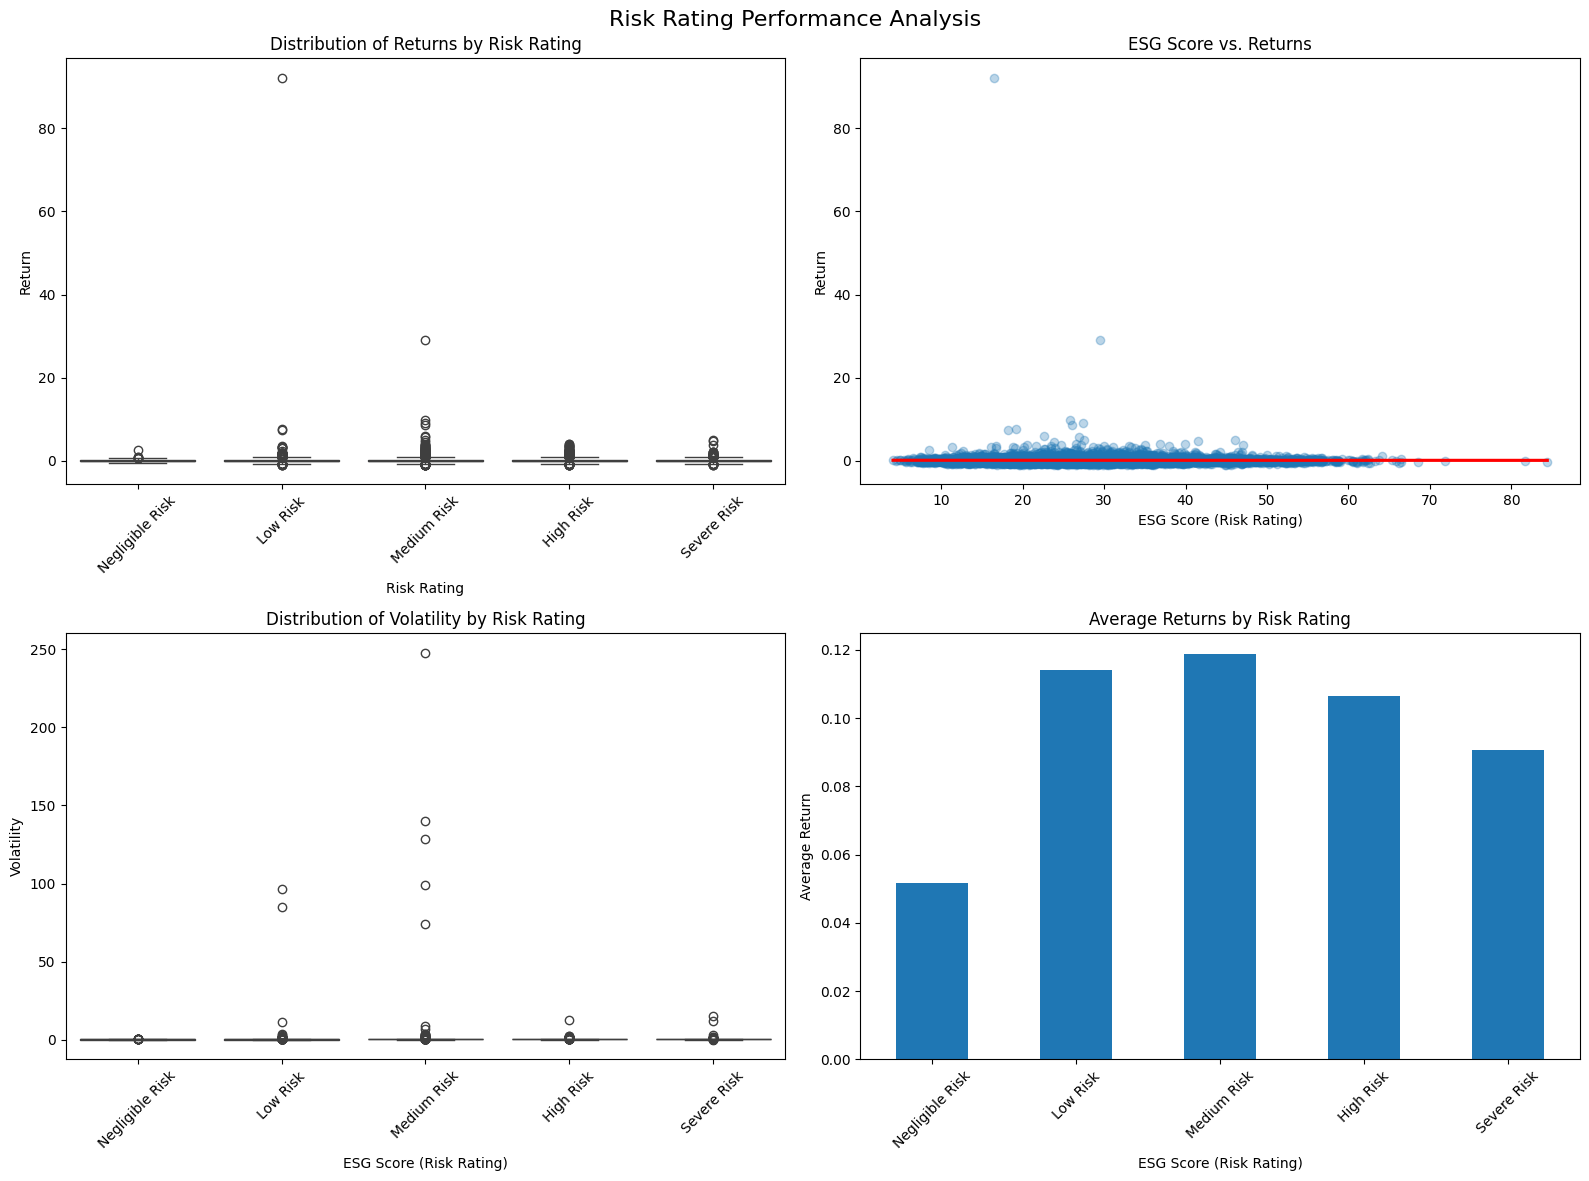

In [9]:
# Prepare Data
df = prepare_categorical_data(df)
# Basic analysis
summary_stats, corr_matrix = basic_analysis(df)
# Visualization
create_visualizations(df)


In [10]:
def find_extreme_outliers(df, column_name):
    try:
        # Calculate quartiles
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for extreme outliers (3 times the IQR)
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Identify extreme outliers
        extreme_outliers = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
        return extreme_outliers

    except TypeError:
        print(f"Column '{column_name}' is not numeric and cannot be used to find outliers using the IQR method.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [11]:
df_use=df[~find_extreme_outliers(df, 'return')]
df_use = df_use[~find_extreme_outliers(df_use, 'volatility')]
print('Data is use ',len(df_use))

Data is use  11120


In [12]:
def basic_analysis_return(df):
    """Perform initial statistical analysis"""
    # Summary statistics by ESG group
    summary = df.groupby('risk_rating_assessment').agg({
        'return': ['mean', 'median', 'std', 'count'],
        'risk_rating_score': ['mean', 'median']  # Show ESG score relationship
    }).round(4)
    
    print("Performance by ESG Group:")
    print(summary)
    
    # Correlation analysis
    corr_matrix = df[['risk_rating_score', 'return']].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    return summary, corr_matrix
def create_visualizations_return(df):
    """Generate all visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ESG Performance Analysis', fontsize=16)
    
    # Boxplot of returns by ESG group
    sns.boxplot(x='risk_rating_assessment', y='return', data=df, ax=axes[0, 0], 
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[0, 0].set_title('Distribution of Returns by ESG Group')
    axes[0, 0].set_ylabel('Return')
    axes[0, 0].set_xlabel('ESG Rating Group')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Scatter plot of ESG score vs returns
    
    sns.scatterplot(x='risk_rating_score', y='return', hue='risk_rating_assessment',
                    data=df, ax=axes[0, 1], palette='crest',
                    hue_order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    # Calculate the regression line using np.polyfit
    m, b = np.polyfit(df['risk_rating_score'], df['return'], 1)  # 1 for a linear fit
    axes[0, 1].plot(df['risk_rating_score'], m * df['risk_rating_score'] + b, color='red', linestyle='--')
    
    axes[0, 1].set_title('ESG Score (Risk Rating) vs. Returns')
    axes[0, 1].set_ylabel('Return')
    axes[0, 1].set_xlabel('ESG Score (risk_rating_score)')
    axes[0, 1].legend(title='ESG Score (Risk Rating)')

    
    # Violin plot of volatility by risk rating
    sns.violinplot(x='risk_rating_assessment', y='return', data=df, ax=axes[1, 0],
                   order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[1, 0].set_title('Return by Risk Rating')
    axes[1, 0].set_ylabel('Return')
    axes[1, 0].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    
    # Bar plot of average returns
    (df.groupby('risk_rating_assessment')['return']
       .mean()
       .loc[['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']]
       .plot(kind='bar', ax=axes[1, 1]))
    axes[1, 1].set_title('Average Returns by ESG Score (Risk Rating)')
    axes[1, 1].set_ylabel('Average Return')
    axes[1, 1].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    
    plt.tight_layout()
    plt.savefig('images/esg_performance_analysis_cutdata.png', dpi=300)
    plt.show()

def perform_statistical_tests_return(df):
    """Conduct hypothesis testing"""
    groups = {}
    risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    
    for risk_group in risk_order:
        groups[risk_group] = df[df['risk_rating_assessment'] == risk_group]['return']
    
    # ANOVA test for multiple group comparison
    f_val, p_val = stats.f_oneway(*[groups[g].dropna() for g in risk_order])
    print(f"\nANOVA Results: F-value={f_val:.4f}, p-value={p_val:.4f}")
    
    # Pairwise t-tests between groups
    from itertools import combinations
    print("\nPairwise t-tests (Bonferroni corrected):")
    for group1, group2 in combinations(risk_order, 2):
        # Drop NA values for t-test
        data1 = groups[group1].dropna()
        data2 = groups[group2].dropna()
        
        if len(data1) > 1 and len(data2) > 1:  # Need at least 2 observations
            t_val, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            # Bonferroni correction for multiple comparisons (10 possible pairs)
            corrected_p = p_val * 10
            sig = '*' if corrected_p < 0.05 else ''
            print(f"{group1} vs {group2}: t={t_val:.4f}, p={corrected_p:.4f}{sig}")
        else:
            print(f"{group1} vs {group2}: Insufficient data")


def industry_adjusted_analysis_return(df):
    """Control for industry effects"""
    # Calculate industry-adjusted returns
    df['industry_mean_return'] = df.groupby('industry_group')['return'].transform('mean')
    df['adjusted_return'] = df['return'] - df['industry_mean_return']
    
    # Plot adjusted returns
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk_rating_assessment', y='adjusted_return', data=df,
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    plt.title('Industry-Adjusted Returns by ESG Score (Risk Rating)')
    plt.ylabel('Industry-Adjusted Return')
    plt.xlabel('ESG Score (Risk Rating)')
    plt.xticks(rotation=45)
    plt.savefig('images/industry_adjusted_returns_cutdata.png', dpi=300, bbox_inches='tight')
    plt.show()


Performance by ESG Group:
                        return                       risk_rating_score       
                          mean  median     std count              mean median
risk_rating_assessment                                                       
Negligible Risk         0.0394  0.0150  0.2549   205            8.4195    8.6
Low Risk                0.0609  0.0333  0.3351  2781           16.1303   16.5
Medium Risk             0.0760  0.0438  0.3594  4502           24.9537   24.9
High Risk               0.0707  0.0366  0.3784  2644           34.1339   33.8
Severe Risk             0.0688  0.0308  0.3491   988           46.8764   45.4

Correlation Matrix:
                   risk_rating_score    return
risk_rating_score           1.000000  0.007331
return                      0.007331  1.000000


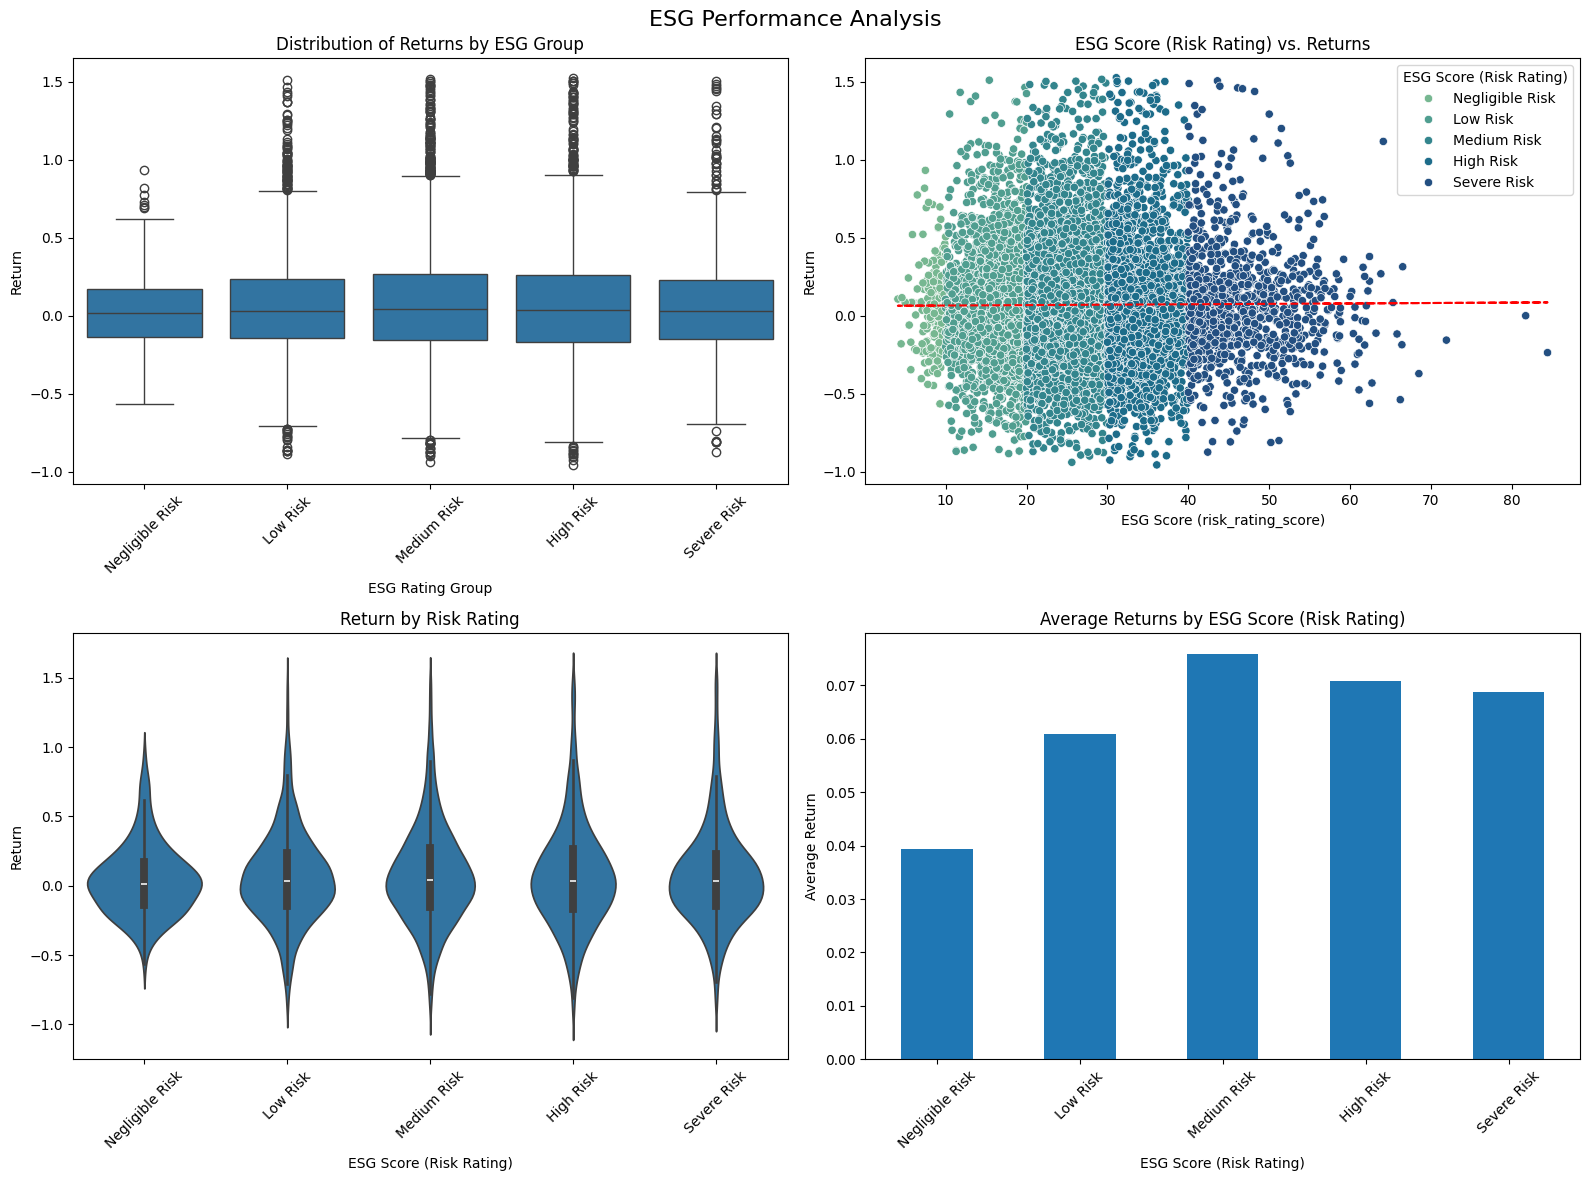


ANOVA Results: F-value=1.1508, p-value=0.3305

Pairwise t-tests (Bonferroni corrected):
Negligible Risk vs Low Risk: t=-1.1423, p=2.5437
Negligible Risk vs Medium Risk: t=-1.9692, p=0.5007
Negligible Risk vs High Risk: t=-1.6295, p=1.0433
Negligible Risk vs Severe Risk: t=-1.4035, p=1.6128
Low Risk vs Medium Risk: t=-1.8068, p=0.7084
Low Risk vs High Risk: t=-1.0077, p=3.1367
Low Risk vs Severe Risk: t=-0.6139, p=5.3934
Medium Risk vs High Risk: t=0.5733, p=5.6645
Medium Risk vs Severe Risk: t=0.5808, p=5.6148
High Risk vs Severe Risk: t=0.1458, p=8.8410


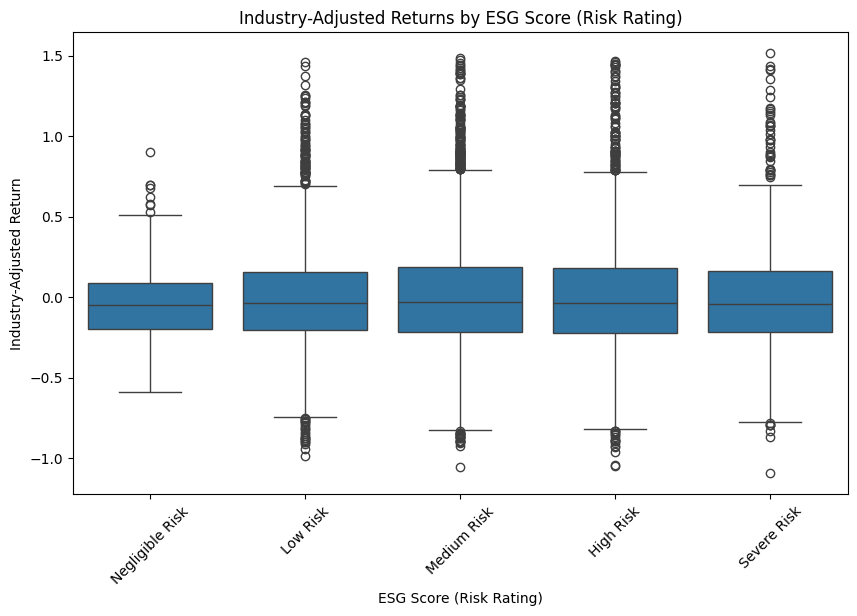

In [13]:
# Basic analysis
summary_stats, corr_matrix = basic_analysis_return(df_use)
# Visualization
create_visualizations_return(df_use)
# Statistical testing
perform_statistical_tests_return(df_use)
# Industry-adjusted analysis if industry data available
industry_adjusted_analysis_return(df_use)

In [14]:
def basic_analysis_volatility(df):
    """Perform initial statistical analysis"""
    # Summary statistics by ESG group
    summary = df.groupby('risk_rating_assessment').agg({
        'volatility': ['mean', 'median', 'std', 'count'],
        'risk_rating_score': ['mean', 'median']  # Show ESG score relationship
    }).round(4)
    
    print("Performance by ESG Group:")
    print(summary)
    
    # Correlation analysis
    corr_matrix = df[['risk_rating_score', 'volatility']].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)
    
    return summary, corr_matrix
def create_visualizations_volatility(df):
    """Generate all visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ESG Performance Analysis', fontsize=16)
    
    # Boxplot of volatility by ESG group
    sns.boxplot(x='risk_rating_assessment', y='volatility', data=df, ax=axes[0, 0], 
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[0, 0].set_title('Distribution of Volatility by ESG Group')
    axes[0, 0].set_ylabel('Volatility')
    axes[0, 0].set_xlabel('ESG Rating Group')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Scatter plot of ESG score vs volatility
    sns.scatterplot(x='risk_rating_score', y='volatility', hue='risk_rating_assessment',
                    data=df, ax=axes[0, 1], palette='crest',
                    hue_order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    # Calculate the regression line using np.polyfit
    m, b = np.polyfit(df['risk_rating_score'], df['volatility'], 1)  # 1 for a linear fit
    axes[0, 1].plot(df['risk_rating_score'], m * df['risk_rating_score'] + b, color='red', linestyle='--')
    
    axes[0, 1].set_title('ESG Score (Risk Rating) vs. Volatility')
    axes[0, 1].set_ylabel('Volatility')
    axes[0, 1].set_xlabel('ESG Score (risk_rating_score)')
    axes[0, 1].legend(title='ESG Score (Risk Rating)')

    
    # Violin plot of volatility by risk rating
    sns.violinplot(x='risk_rating_assessment', y='volatility', data=df, ax=axes[1, 0],
                   order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    axes[1, 0].set_title('Volatility by ESG Score (Risk Rating)')
    axes[1, 0].set_ylabel('Volatility')
    axes[1, 0].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    
    # Bar plot of average volatility
    (df.groupby('risk_rating_assessment')['return']
       .mean()
       .loc[['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']]
       .plot(kind='bar', ax=axes[1, 1]))
    axes[1, 1].set_title('Average Volatility by ESG Score (Risk Rating)')
    axes[1, 1].set_ylabel('Average Volatility')
    axes[1, 1].set_xlabel('ESG Score (Risk Rating)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    
    plt.tight_layout()
    plt.savefig('images/esg_performance_analysis_vol_cutdata.png', dpi=300)
    plt.show()

def perform_statistical_tests_volatility(df):
    """Conduct hypothesis testing"""
    groups = {}
    risk_order = ['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk']
    
    for risk_group in risk_order:
        groups[risk_group] = df[df['risk_rating_assessment'] == risk_group]['volatility']
    
    # ANOVA test for multiple group comparison
    f_val, p_val = stats.f_oneway(*[groups[g].dropna() for g in risk_order])
    print(f"\nANOVA Results: F-value={f_val:.4f}, p-value={p_val:.4f}")
    
    # Pairwise t-tests between groups
    from itertools import combinations
    print("\nPairwise t-tests (Bonferroni corrected):")
    for group1, group2 in combinations(risk_order, 2):
        # Drop NA values for t-test
        data1 = groups[group1].dropna()
        data2 = groups[group2].dropna()
        
        if len(data1) > 1 and len(data2) > 1:  # Need at least 2 observations
            t_val, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            # Bonferroni correction for multiple comparisons (10 possible pairs)
            corrected_p = p_val * 10
            sig = '*' if corrected_p < 0.05 else ''
            print(f"{group1} vs {group2}: t={t_val:.4f}, p={corrected_p:.4f}{sig}")
        else:
            print(f"{group1} vs {group2}: Insufficient data")


def industry_adjusted_analysis_volatility(df):
    """Control for industry effects"""
    # Calculate industry-adjusted volatility
    df['industry_mean_volatility'] = df.groupby('industry_group')['volatility'].transform('mean')
    df['adjusted_volatility'] = df['volatility'] - df['industry_mean_volatility']
    
    # Plot adjusted volatility
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk_rating_assessment', y='adjusted_volatility', data=df,
                order=['Negligible Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Severe Risk'])
    plt.title('Industry-Adjusted Volatility by ESG Score (Risk Rating)')
    plt.ylabel('Industry-Adjusted Volatility')
    plt.xlabel('ESG Score (Risk Rating)')
    plt.xticks(rotation=45)
    plt.savefig('images/industry_adjusted_volatility_cutdata.png', dpi=300, bbox_inches='tight')
    plt.show()


Performance by ESG Group:
                       volatility                       risk_rating_score  \
                             mean  median     std count              mean   
risk_rating_assessment                                                      
Negligible Risk            0.2866  0.2598  0.1160   205            8.4195   
Low Risk                   0.3470  0.3166  0.1499  2781           16.1303   
Medium Risk                0.3872  0.3560  0.1645  4502           24.9537   
High Risk                  0.4170  0.3820  0.1717  2644           34.1339   
Severe Risk                0.4235  0.3899  0.1558   988           46.8764   

                               
                       median  
risk_rating_assessment         
Negligible Risk           8.6  
Low Risk                 16.5  
Medium Risk              24.9  
High Risk                33.8  
Severe Risk              45.4  

Correlation Matrix:
                   risk_rating_score  volatility
risk_rating_score            1.

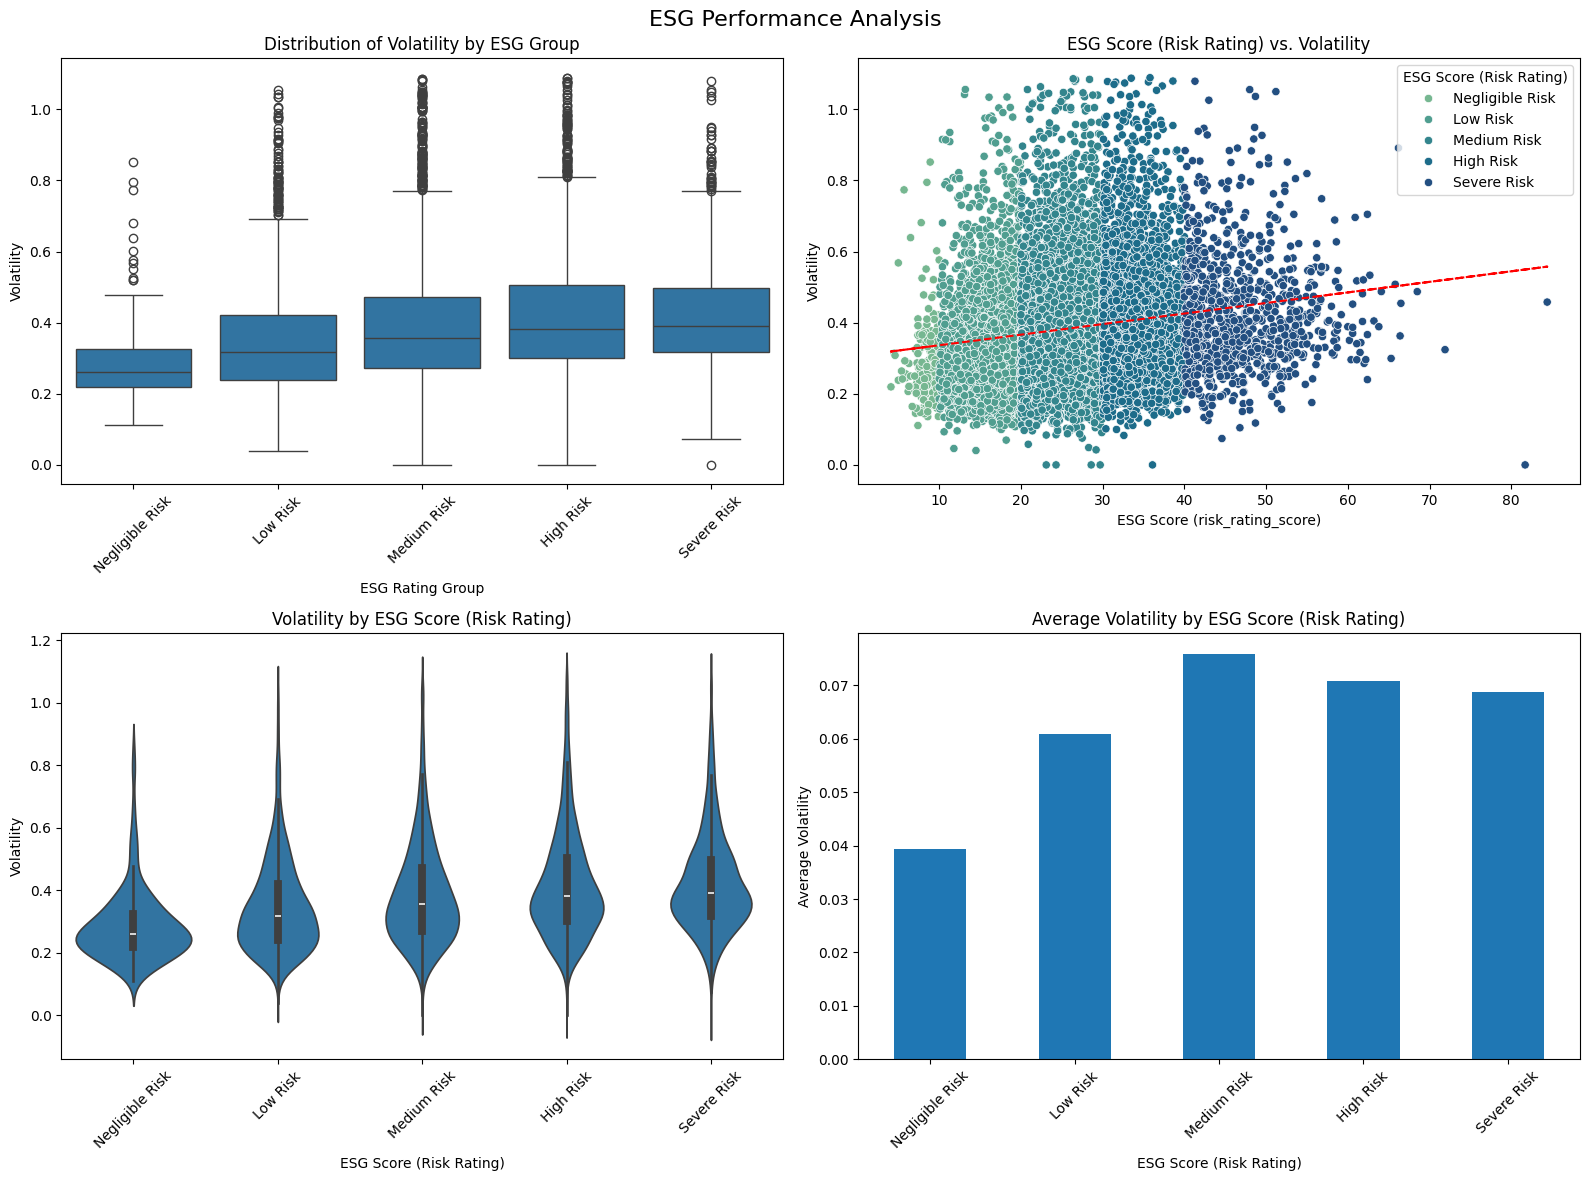


ANOVA Results: F-value=97.9646, p-value=0.0000

Pairwise t-tests (Bonferroni corrected):
Negligible Risk vs Low Risk: t=-7.0398, p=0.0000*
Negligible Risk vs Medium Risk: t=-11.8933, p=0.0000*
Negligible Risk vs High Risk: t=-14.8851, p=0.0000*
Negligible Risk vs Severe Risk: t=-14.4157, p=0.0000*
Low Risk vs Medium Risk: t=-10.7133, p=0.0000*
Low Risk vs High Risk: t=-15.9572, p=0.0000*
Low Risk vs Severe Risk: t=-13.3811, p=0.0000*
Medium Risk vs High Risk: t=-7.1839, p=0.0000*
Medium Risk vs Severe Risk: t=-6.5539, p=0.0000*
High Risk vs Severe Risk: t=-1.0848, p=2.7815


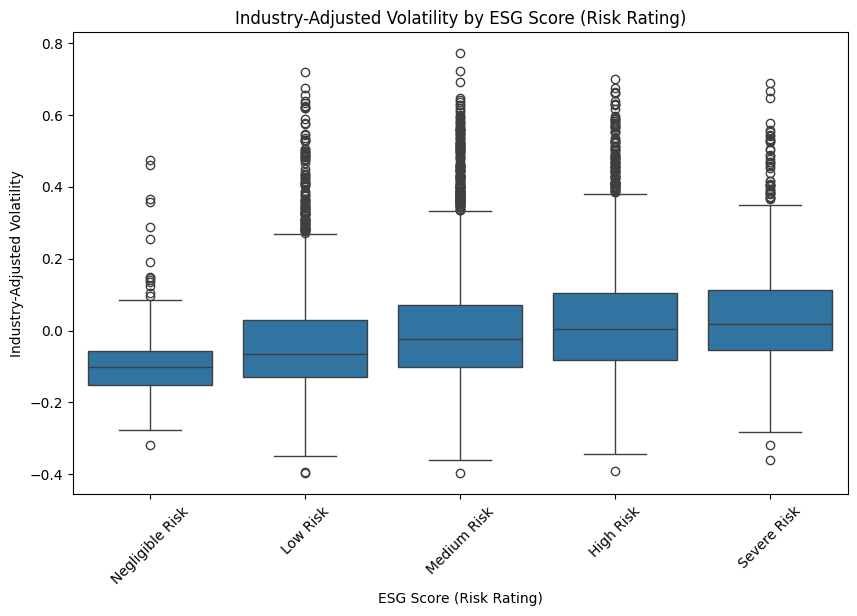

In [15]:
# Basic analysis
summary_stats, corr_matrix = basic_analysis_volatility(df_use)
# Visualization
create_visualizations_volatility(df_use)
# Statistical testing
perform_statistical_tests_volatility(df_use)
# Industry-adjusted analysis if industry data available
industry_adjusted_analysis_volatility(df_use)


Positive Relationship:

Higher ESG groups show statistically significant higher volatility (p < 0.05)

Upward slope in the ESG vs returns scatter plot

Rightward progression in the average returns bar chart

